# Vision artificielle - TP Traitement d'images

L'objectif de ce TP est de se familiariser avec quelques techniques classiques de traitement d'images.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imsave, imshow

# Images de test

Quelques images de test sont fournies avec ce notebook.
Vous pouvez les utiliser tout au long de la séance pour afficher et vérifier vos résultats.

Voici la liste :

In [2]:
%ls

barbara.png      lena.png           scotland_house.jpg
cameraman.png    lena-rgb.png       scotland_plain.jpg
fingerprint.png  mandril_color.png  test-histo1.png
house.png        page.png           test-histo2.png
lake.png         peppers.png        tp-traitement-images.ipynb


Quelques exemples :

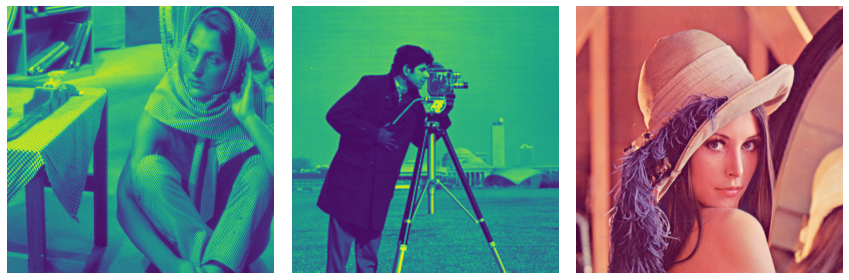

In [40]:
list_images = ['barbara.png', 'cameraman.png', 'lena-rgb.png']
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(131+i)
    im = imread(list_images[i])
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

Lorsque vous effectuez des transformations sur les images, faites attention aux types que vous manipulez.
Par exemple, si une image est en `uint8` (pixels codés sur un 1 octet), les valeurs sont limitées à l'intervalle $[0, 255]$.
N'hésitez pas à convertir si nécessaire, par exemple avec la fonction `astype` (ou à vérifier le type après une opération).

In [4]:
im = imread('barbara.png')
print(im.dtype)
topleft = im[0, 0]
im[0, 0] = -1 # Impossible en uint8
print(im[0, 0])

im = im.astype(int)
print(im.dtype)
im[0, 0] = -1 # OK
print(im[0, 0])

im[0, 0] = topleft
im = np.log(1 + im) # Conversion en float
print(im.dtype)

uint8
255
int64
-1
float64


Au besoin, il faut également spécifier les valeurs minimales et maximales de la fonction d'affichage `imshow` :

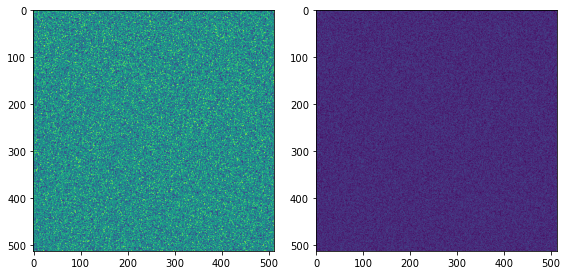

In [5]:
im = np.random.randint(0, 64, size=(512, 512), dtype=np.uint8) # Pixels aléatoires entre 0 et 64
plt.figure(figsize=(8, 4))
plt.subplot(121); plt.imshow(im) # De base, imshow remet à l'échelle les valeurs
plt.subplot(122); plt.imshow(im, vmin=0, vmax=255) # Spécifier vmin et vmax
plt.tight_layout()

# Manipulation d'histogramme

L’histogramme d'une image à niveaux de gris est défini comme l'ensemble des fréquences d’apparition des différentes valeurs des pixels.
Pour chaque niveau de gris possible (entre 0 et 255 pour une image codée sur 8 bits), on associe le nombre de pixels dans l'image qui ont cette valeur.

Généralement, on normalise les valeurs de l'histogramme par le nombre total de pixels de l'image : l'histogramme peut alors être assimilé à une distribution de probabilités.

L'histogramme nous informe sur la répartition des niveaux de gris (contraste), ainsi que sur les niveaux de gris les plus représentés (modes).
Il est cependant dépourvu de toute information spatiale.

1. Calculer et afficher l'histogramme d'une image. Tester le résultat pour le plusieurs images. Penser également à normaliser l'histogramme par le nombre de pixels dans l'image.

In [122]:
def plotHist(image, d = False, c = False):
    
    values = []
    edges = []
    
    # Single channel images
    if len(image.shape) == 2:
        
        b = len(list(set(image.flatten())))
        n, bins, _ = plt.hist(image.flatten(), bins = b, density = d, cumulative = c, color = 'b')
        values.append(n)
        edges.append(bins)

    # Multiple channels images
    else:
        for i in range(image.shape[2]):
            
            b = len(list(set(image[:,:,i].flatten())))
            
            n, bins, _ = plt.hist(image[:,:,i].flatten(), bins = b, density = d, cumulative = c, color = 'b')
            values.append(n)
            edges.append(bins)
            plt.title("Histogram for channel " + str(i))
            plt.show()
            
    return values, edges

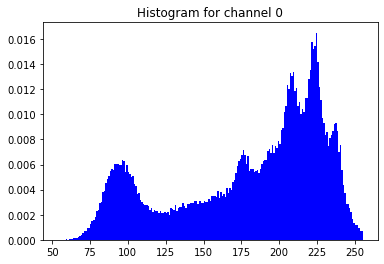

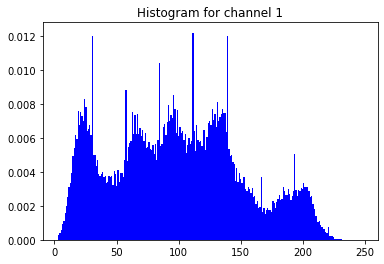

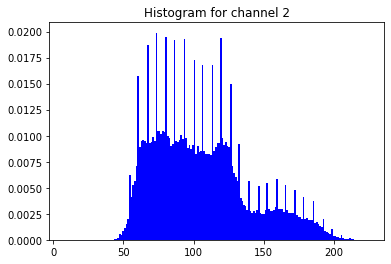

In [123]:
im = imread('lena-rgb.png')
values, edges = plotHist(im, d = True)

2. Appliquer un étirement d'histogramme sur une image. Utiliser par exemple les images `test-histo1.png` et `test-histo2.png`.

Rappel : l'étirement d'histogramme consiste simplement à répartir les fréquences d'apparition des pixels sur toute la largeur de l'histogramme.

In [94]:
def stretch(image):
    
    max_val = np.max(image)
    min_val = np.min(image)
    
    #print(max_val)
    #print(min_val)
    
    s = lambda x: 255 * ((x - min_val) / (max_val - min_val))
    
    toret = np.copy(image)
    
    return s(toret)

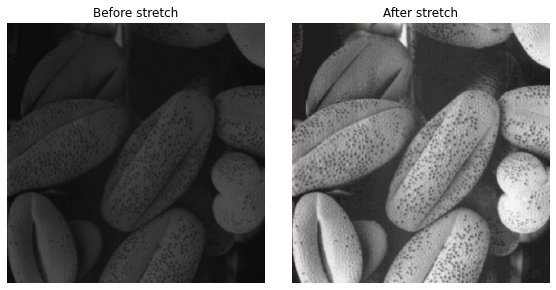

In [95]:
test1 = imread('test-histo1.png')
test2 = imread('test-histo2.png')

t1 = stretch(test1).astype('uint8')

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(test1)
plt.title("Before stretch")
plt.axis('off')
plt.subplot(132)
plt.imshow(t1)
plt.title("After stretch")
plt.axis('off')

plt.tight_layout()

3. Appliquer une égalisation d'histogramme sur une image. Utiliser par exemple les images `test-histo1.png` et `test-histo2.png`.

Rappel : les pixels de valeur $k$ auront pour nouvelle valeur $255 \times C(k)$ où $C(k) = \sum_0^k H(k)$

In [174]:
def getClass(p, bins):
    
    return np.argmax(bins>p) - 1 

def equalize(image, values, bins):
    
    new_image = np.copy(image)
    
    if len(image.shape) == 2:
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                new_image[i,j] = 255 * values[0][getClass(image[i,j], bins[0])]
        
    else:   
        for c in range(image.shape[2]):
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    new_image[i,j,c] = 255 * values[c][getClass(image[i,j,c], bins[c])]
        
    
    return new_image

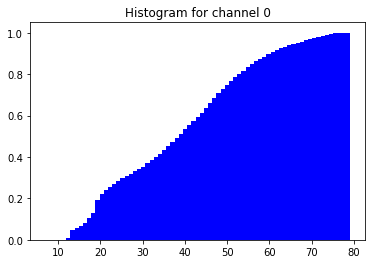

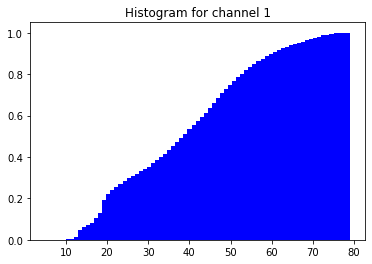

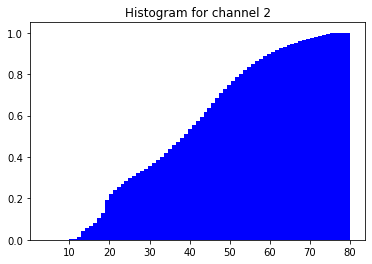

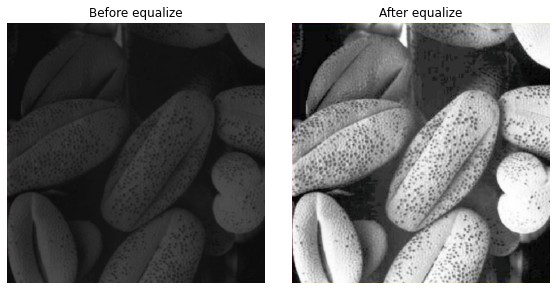

In [176]:
# Compute Cumulative histograms
# values contains C(k), and bins the borders of each class k
values, bins = plotHist(test1, d = True, c = True)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(test1)
plt.title("Before equalize")
plt.axis('off')
plt.subplot(132)
plt.imshow(equalize(test1, values, bins))
plt.title("After equalize")
plt.axis('off')

plt.tight_layout()

4. Appliquer des opérations de binarisation par seuillage à différents niveaux. Utiliser par exemple les images `fingerprint.png` et `page.png`. Tester la méthode d'Otsu dans la librairie `skimage` pour déterminer automatiquement un seuil.

# Filtrage spatial par convolution

1. Coder une fonction permettant de réaliser une convolution par un filtre de taille impaire.

2. Utiliser cette fonction pour appliquer un filtre moyenneur et un filtre gaussien. Observer les résultats pour différentes images.

Le filtre médian est un filtre non linéaire qui consiste à remplacer la valeur de chaque pixel par la valeur médiane de son voisinage.

3. Appliquer un filtre médian sur l'image

# Détection de contours

1. Appliquer les filtres de Prewitt et de Sobel sur des images de test et afficher les images du gradient horizontal et vertical.

2. Calculer l'intensité du gradient et appliquer différents seuillages pour binariser la carte de contours.